* #  Name : Abhilakshya Mehta
* #  Roll no. : 21f1002251

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


# **Table of Contents**

* ## [Imports](#imports)

* ## [Data Loading](#data_loading)

* ## [Features and Label Split](#feature_label_split)

* ## [Data Preprocessing](#data_preprocessing)

* ## [EDA after Preprocessing](#eda)
    * ### [For Feature Matrix](#edafm)
    * ### [For Target Vector](#edatv)

* ## [Recursive Feature Elimination](#rfe)

* ## [Model Engineering](#model_engineering)

  * ### [Basic Linear Regression](#linear_r)

  * ### [SGD Regressor Modelling](#sgd_r)
    * [With Hyperparameter Tuning](#sgd_hpt)
    * [With Default Parameters](#sgd_default)
    * [With Best Parameters](#sgd_best)

  * ### [LightGBM Regressor Modelling](#lgbm_r)
    * [With Hyperparameter Tuning](#lgbm_hpt)
    * [With Default Parameters](#lgbm_default)
    * [With Best Parameters](#lgbm_best)


  * ### [Random Forest Regressor Modelling](#rf_r)

  * ### [Gradient Boosintg Modelling](#gb_r)

* ## [Model Comparision](#model_comparision)

* ## [Conclusion](#conclusion)

* ## [Final Submission](#final_submission)
    * ### [Submission Code](#sc)

# Imports <a class="anchor"  id="imports"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,SGDRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor


# Data Loading <a class="anchor"  id="data_loading"></a>

In [4]:
df = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [5]:
df.shape

(175000, 17)

In [6]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [7]:
print(df.describe())

            VendorID  passenger_count  trip_distance     RatecodeID  \
count  175000.000000    168923.000000  175000.000000  168923.000000   
mean        0.728377         1.357678       5.145930       1.518307   
std         0.445606         0.891283     394.971052       6.514678   
min         0.000000         0.000000       0.000000       1.000000   
25%         0.000000         1.000000       1.080000       1.000000   
50%         1.000000         1.000000       1.840000       1.000000   
75%         1.000000         1.000000       3.610000       1.000000   
max         2.000000         9.000000  135182.060000      99.000000   

        PULocationID   DOLocationID          extra     tip_amount  \
count  175000.000000  175000.000000  175000.000000  175000.000000   
mean      132.710349     132.701429       1.932143       6.127497   
std        76.148799      76.192493       1.948497       4.610834   
min         1.000000       1.000000      -7.500000       0.000079   
25%        67.0

passenger_count: The average number of passengers is around 1.36, with a majority of trips having one passenger.
There are trips with zero passengers, which might be anomalies or errors in the data.

trip_distance: The average trip distance is 5.15, but the standard deviation is very high, indicating the presence of outliers.
The minimum distance is 0, which might indicate trips that didn't cover any distance (perhaps canceled trips).


tolls_amount: The average tolls amount is 0.65, but the distribution has a high standard deviation, indicating variability.
There are negative toll amounts, which might be errors or refunds.

total_amount: The average total amount is 29.63, with a wide range and potential outliers.
There are negative total amounts, which might be data issues or refunds.

Airport_fee: The airport fee is mostly 0, with a small positive mean, indicating that it is applied in some cases.


In [8]:
df.isnull().sum()

VendorID                    0
tpep_pickup_datetime        0
tpep_dropoff_datetime       0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
dtype: int64

payment_type
Credit Card    135257
Cash            30141
Wallet           6077
unknown          2333
UPI              1192
Name: count, dtype: int64


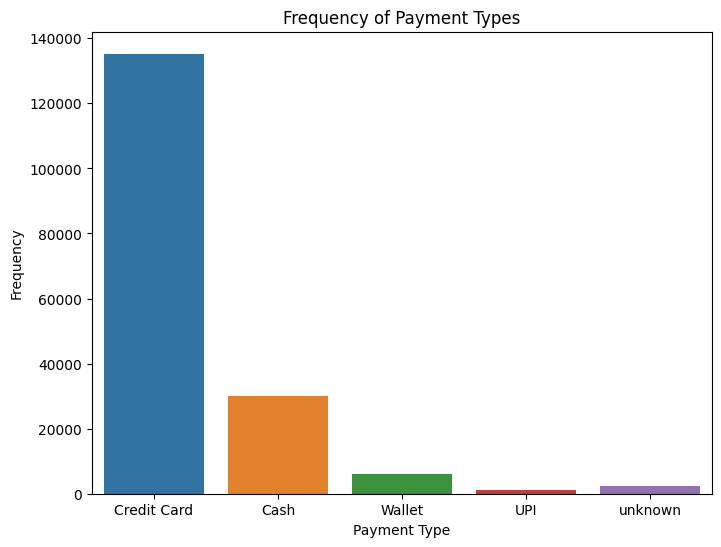

In [9]:
print(df.payment_type.value_counts())

# Bar plot for frequency of 'payment_type'
plt.figure(figsize=(8, 6))
sns.countplot(x='payment_type', data=df)
plt.title('Frequency of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Frequency')
plt.show()


It shows that maximum users pay with Credit Card.

# Features and Label Split <a class="anchor"  id="feature_label_split"></a>

In [10]:
X = df.drop('total_amount', axis=1)
y = df['total_amount']

# Data Preprocessing <a class="anchor"  id="data_preprocessing"></a>


*   Date Type features transformation and extraction
*   Imputation, One Hot Encoding
*   Feature Scaling, Drop Features
*   Created a data preprocessing Pipeline

In [11]:
# Date Time feature Transformation
def date_time_process(df):
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['trip_duration'] = ((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60)
    df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df = df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)
    return df

In [12]:
numeric_features = ['passenger_count', 'trip_distance', 'extra', 'tip_amount',
                    'tolls_amount','improvement_surcharge', 'congestion_surcharge', 'Airport_fee',
                    'trip_duration', 'pickup_day_of_week', 'pickup_hour']

categorical_features = ['store_and_fwd_flag', 'payment_type']

nominal_features = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID']


pipe_nominal = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent'))
])

pipe_categorical = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehotencode', OneHotEncoder(handle_unknown='ignore'))
])

pipe_numeric = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler(with_mean=True, with_std=True))
])

CT = ColumnTransformer(transformers=[
    ('nominal', pipe_nominal, nominal_features),
    ('categorical', pipe_categorical, categorical_features),
    ('numeric', pipe_numeric, numeric_features)
], remainder='passthrough')

In [13]:
def convert_back_dataframe(X):

    nominal_features_name = CT.transformers_[0][2]
    categorical_features_name = list(CT.transformers_[1][1].named_steps['onehotencode'].get_feature_names_out(CT.transformers_[1][2]))
    numeric_features_name = CT.transformers_[2][2]

    X_transformed_pd = pd.DataFrame(X, columns=nominal_features_name+categorical_features_name+numeric_features_name) 
    
    return X_transformed_pd

Data Preprocessing

In [14]:
X = date_time_process(X)

X_transformed = CT.fit_transform(X)

X_transformed = convert_back_dataframe(X_transformed)


# Feature Matrix EDA <a class="anchor"  id="edafm"></a>

In [15]:
X_transformed.head()

,VendorID,RatecodeID,PULocationID,DOLocationID,store_and_fwd_flag_N,store_and_fwd_flag_Y,payment_type_Cash,payment_type_Credit Card,payment_type_UPI,payment_type_Wallet,...,trip_distance,extra,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,Airport_fee,trip_duration,pickup_day_of_week,pickup_hour
0,1.0,1.0,120.0,9.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.007611,0.291434,0.225142,-0.27781,0.102183,0.314375,-0.315757,-1.019752,-1.594159,0.326181
1,0.0,1.0,15.0,215.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.006193,0.804651,-0.013034,-0.27781,0.102183,0.314375,-0.315757,-1.306170,-0.253016,1.365627
2,1.0,1.0,167.0,223.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.010117,-0.991610,-0.437221,-0.27781,0.102183,0.314375,-0.315757,0.574288,1.088126,-0.886505
3,0.0,1.0,128.0,239.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.012016,0.291434,0.061504,-0.27781,0.102183,0.314375,-0.315757,0.625950,-0.253016,-0.366783
4,1.0,1.0,203.0,52.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.010244,-0.478392,-0.294551,-0.27781,0.102183,0.314375,-0.315757,0.015103,-0.253016,1.192386


In [16]:
X_transformed.shape

(175000, 22)

In [17]:
X_transformed.isnull().sum().sum()

0

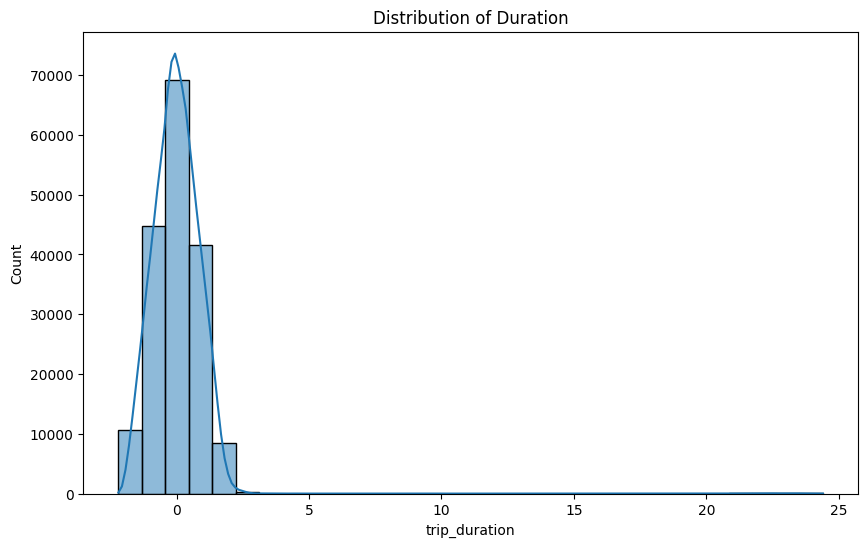

In [18]:
# Distribution 
plt.figure(figsize=(10, 6))
sns.histplot(X_transformed['trip_duration'], bins=30, kde=True)
plt.title('Distribution of Duration')
plt.show()

### Correlation between features

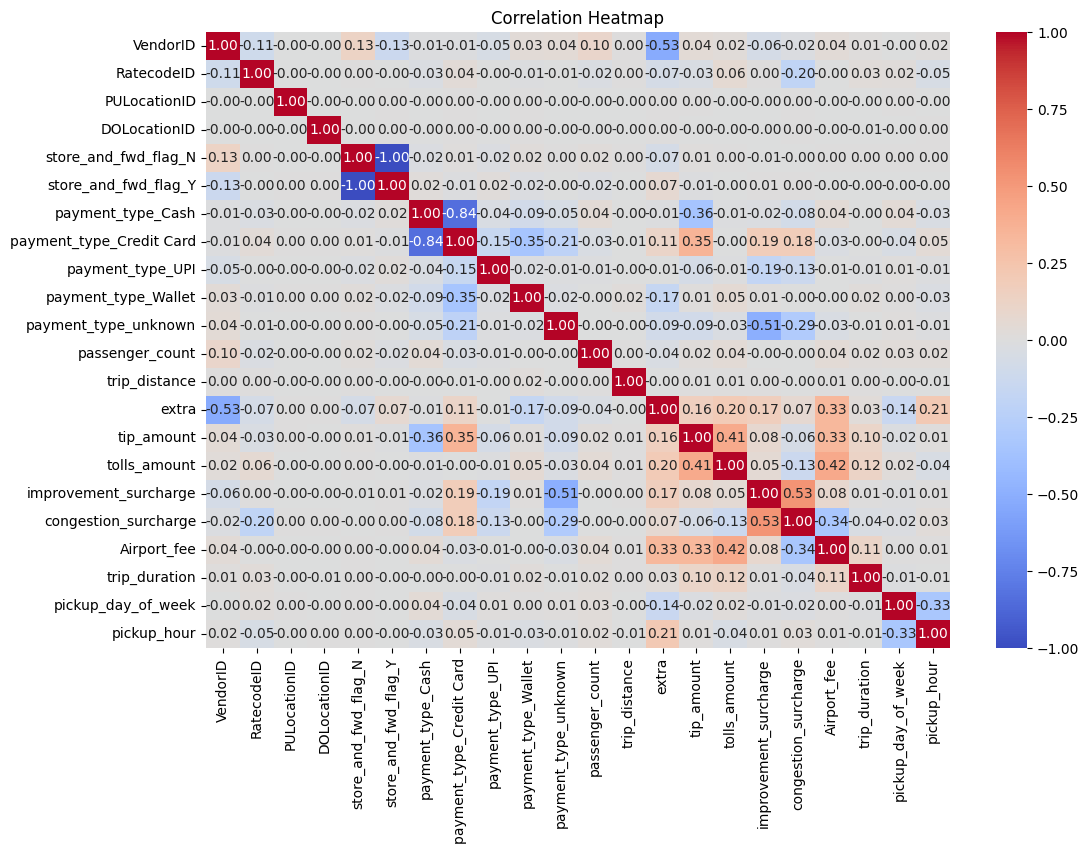

In [19]:
# Correlation heatmap
correlation_matrix = X_transformed.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

There is Strong Positive Correlation between: 
* Credit Card & Tip Amount (0.35)
* Airport Fee & Toll Amount (0.42)
* Tip Amount & Toll Amount (0.41)
* Congestion surcharge & Improvement Surcharge (0.53)

There is Strong Negative Correlation between: 
* Credit Card & Cash (-0.84)
* Cash & Tip Amount (-0.36)

### Correlation of Each feature with Total Amount

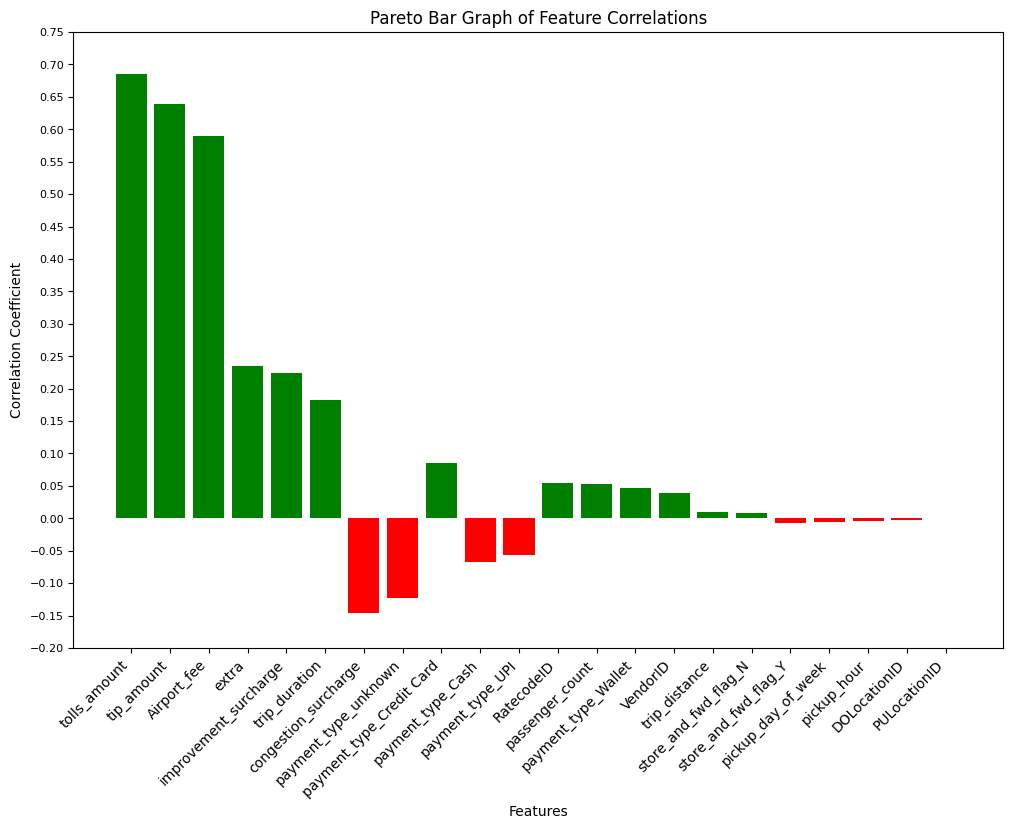

In [20]:
def calculate_correlation(vector1, vector2):
    df = pd.DataFrame({'vector1': vector1, 'vector2': vector2})
    correlation_result = df.corr().iloc[0, 1]
    return round(correlation_result, 4)

corr = {}
for feature in X_transformed.columns:
    corr[feature] = calculate_correlation(X_transformed[feature], y)
    
    
# Sort the dictionary by absolute values of correlation in descending order
sorted_corr = dict(sorted(corr.items(), key=lambda x: abs(x[1]), reverse=True))


features = list(sorted_corr.keys())
correlation_values = list(sorted_corr.values())

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(features, correlation_values, color=['red' if val < 0 else 'green' for val in correlation_values])
ax.set_xlabel('Features')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Pareto Bar Graph of Feature Correlations')

plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(-0.2, 0.8, 0.05), fontsize=8)

plt.show()

# Target Vector EDA <a class="anchor"  id="edmtv"></a>

In [21]:
# Descriptive Stats of Target 
y.describe()

count    175000.000000
mean         29.633901
std          25.425206
min        -576.750000
25%          16.300000
50%          21.450000
75%          31.800000
max         587.250000
Name: total_amount, dtype: float64

### Distribution of Target 

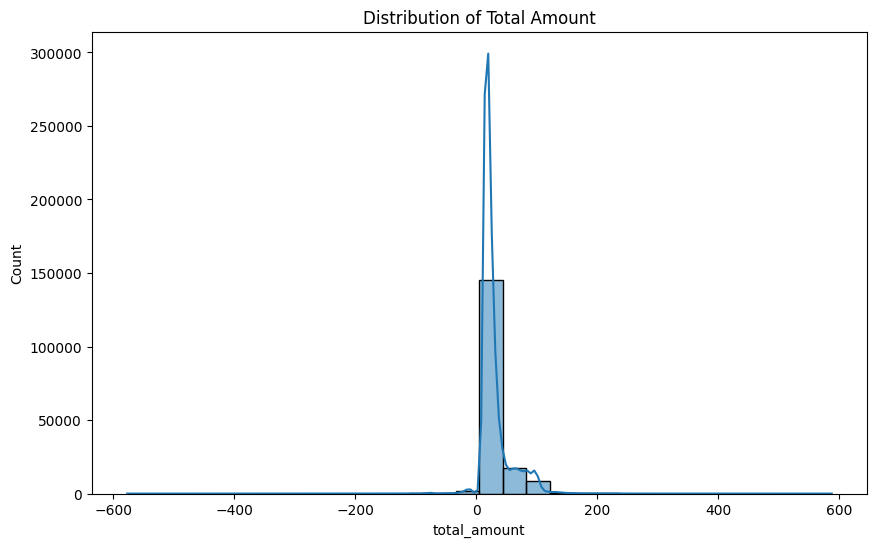

In [22]:
# Distribution 
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)
plt.title('Distribution of Total Amount')
plt.show()

This suggest that Target LAbel (i.e. total_amount) follows Normal Distribution.

# Dataset SETUP for Modelling 
* Train-Validation Split (70:30 Ratio)
* RFE 

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.30, random_state=42)

# RFE <a class="anchor"  id="rfe"></a>

In [24]:
# rfe = RFE(LGBMRegressor(), 
#           n_features_to_select=14, verbose=1, step=4)

# # Fit the RFE model to the training data
# rfe.fit(X_train, y_train)

In [25]:
# # Get the selected features
# selected_features = list(rfe.support_)


# features_to_keep = []
# features_to_drop = []

# for i in range(len(selected_features)):
#     if selected_features[i] == False:
#         features_to_drop.append(X_train.columns[i])
#     else:
#         features_to_keep.append(X_train.columns[i])

        
# print(features_to_drop)
# print(features_to_keep)

In [26]:
# X_train = rfe.transform(X_train)
# X_val = rfe.transform(X_val)

In [27]:
X_train.shape

(122500, 22)

# Model Engineering <a class="anchor"  id="model_engineering"></a>

* ### [Basic Linear Regression](#linear_r)

* ### [SGD Regressor Modelling](#sgd_r)
    * [With Hyperparameter Tuning](#sgd_hpt)
    * [With Default Parameters](#sgd_default)
    * [With Best Parameters](#sgd_best)

* ### [LightGBM Regressor Modelling](#lgbm_r)
    * [With Hyperparameter Tuning](#lgbm_hpt)
    * [With Default Parameters](#lgbm_default)
    * [With Best Parameters](#lgbm_best)

* ### [Random Forest Regressor Modelling](#rf_r)

* ### [Gradient Boosintg Modelling](#gb_r)

In [28]:
scores = {}

In [29]:
def calculate_score(model_name, model, scores):
    scores[model_name] = {
        'Train Score' : round(model.score(X_train, y_train), 4),
        'Test Score' : round(model.score(X_val, y_val), 4)
    }
    
    return scores

## HPT

In [30]:
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    # Use RandomizedSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model,param_grid=param_grid, cv=KFold(), n_jobs=-1, verbose=2)

    # Fit the RandomizedSearchCV object to the data
    grid_search.fit(X_train, y_train)

    # Return the tuned model
    return grid_search.best_estimator_, grid_search.best_params_

## Basic Linear Regression <a class="anchor"  id="linear_r"></a>

In [31]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

scores = calculate_score("Linear Regression", lr_model, scores)

## SGDRegressor  <a class="anchor"  id="sgd_r"></a>

### With Default Parameters 
Scores: Train Score: -3.456228462639449e+21, Test Score: -3.4729716209689197e+21
        
### With Hyperparameter Tuning using GridSearchCV <a class="anchor"  id="sgd_hpt"></a>

Parameter set : {
                    'loss' : ['squared_error', 'huber'],
                    'penalty': ['l2', 'l1', None],
                    'fit_intercept':[True, False],
                    'learning_rate' : ['invscaling', 'optimal', 'adaptive'],
                    'alpha': [0.1,0.01,0.001],
                    'early_stopping': [True]
                    }
                    
Best Parameters : {
                   'alpha': 0.1, 
                   'early_stopping': True, 
                   'fit_intercept': True, 
                   'learning_rate': 'adaptive', 
                   'loss': 'huber', 
                   'penalty': None
                   }   
                   
Scores : Train Score: 0.7184489944097283, Test Score: 0.7179513964703672

In [32]:
# param_grid = {
#     'loss' : ['squared_error', 'huber'],
#     'penalty': ['l2', 'l1', None],
#     'fit_intercept':[True, False],
#     'learning_rate' : ['invscaling', 'optimal', 'adaptive'],
#     'alpha': [0.1,0.01,0.001],
#     'early_stopping': [True]
# }

# sgd_model, best_parameter = hyperparameter_tuning(SGDRegressor(random_state=42), param_grid, X_train, y_train)


# print(best_parameter)

# sgd_model.fit(X_train, y_train)

# scores = calculate_score("SGD Regression", sgd_model, scores)

### With Default Parameters <a class="anchor"  id="sgd_default"></a>

In [33]:
# default_sgd_model = SGDRegressor(alpha=0.001, learning_rate='optimal', power_t=0.5, random_state=42)
# default_sgd_model.fit(X_train, y_train)
# scores = calculate_score("SGD Regression", default_sgd_model, scores)

## With Best Parameters <a class="anchor"  id="sgd_best"></a>

In [34]:
best_parameters = {
    'alpha': 0.1,
    'early_stopping': True,
    'fit_intercept': True,
    'learning_rate': 'adaptive',
    'loss': 'huber',
    'penalty': None 
}

best_sgd_model = SGDRegressor(**best_parameters, random_state=42)
best_sgd_model.fit(X_train, y_train)
scores = calculate_score("SGD Regression with best params", best_sgd_model, scores)

## LightGBM Model <a class="anchor"  id="lgbm_r"></a>

### With Default Parameters 
Scores: Train Score: 0.9571051283778902, Test Score: 0.9338405824046442
        
### With Hyperparameter Tuning using GridSearchCV <a class="anchor"  id="lgbm_hpt"></a>

Parameter set : {
                    'learning_rate': [0.01, 0.1],
                    'num_leaves' : [45, 50, 70],
                    'num_iterations' : [1000, 1500]
                    }
                    
                    
Best Parameters : {'learning_rate': 0.01, 'num_iterations': 1000, 'num_leaves': 45}   
                   
Scores : Train Score: 0.9624163248559031, Test Score: 0.9363384679832895

In [35]:
# param_grid= {
#     'learning_rate': [0.01, 0.1],
#     'num_leaves' : [45, 50, 70],
#     'num_iterations' : [1000, 1500]
# } 

# lgbm_model, best_parameter = hyperparameter_tuning(LGBMRegressor(n_jobs=-1, random_state=42), param_grid, X_train, y_train)


# print(best_parameter)

# lgbm_model.fit(X_train, y_train)

# scores = calculate_score("LGBM Regressor", lgbm_model, scores)



### With Default Parameters <a class="anchor"  id="lgbm_default"></a>

In [36]:
default_lgbm_model = LGBMRegressor(n_jobs=-1)

default_lgbm_model.fit(X_train, y_train)

scores = calculate_score("LightGBM Regressor", default_lgbm_model, scores)

### With Best Parameters <a class="anchor"  id="lgbm_default"></a>

In [37]:
best_parameters = {
    'learning_rate': 0.01,
    'num_iterations': 1000,
    'num_leaves': 45
}

best_lgbm_model = LGBMRegressor(**best_parameters, n_jobs=-1)

best_lgbm_model.fit(X_train, y_train)

scores = calculate_score("LightGBM Regressor with best params", best_lgbm_model, scores)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


## Random Forest Model <a class="anchor"  id="rf_r"></a>

In [38]:
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, y_train)

scores = calculate_score("Random Forest Regression", rf_model, scores)

## Gradient Boosting Model <a class="anchor"  id="gb_r"></a>

In [39]:
gb_model = GradientBoostingRegressor(verbose=2)

gb_model.fit(X_train, y_train)

scores = calculate_score("Gradient Boosting Regressor", gb_model, scores)

      Iter       Train Loss   Remaining Time 
         1         553.0837           28.73s
         2         476.9380           28.48s
         3         413.3508           28.57s
         4         360.9330           28.28s
         5         316.0213           28.12s
         6         278.3927           28.01s
         7         246.4903           27.82s
         8         220.1388           27.58s
         9         197.4934           27.33s
        10         178.5699           27.07s
        11         161.4021           26.78s
        12         147.0020           26.50s
        13         134.5149           26.24s
        14         123.8770           25.87s
        15         115.2173           25.54s
        16         107.5154           25.26s
        17         100.8267           24.97s
        18          95.3819           24.65s
        19          90.4404           24.39s
        20          85.7434           24.20s
        21          81.8043           23.89s
        2

## MLPRegressor

In [40]:
# from sklearn.neural_network import MLPRegressor

# mlp_r = MLPRegressor(hidden_layer_sizes=(100,100, 100), activation='relu', alpha=0.001, early_stopping=True, )

# mlp_r.fit(X_train, y_train)

# scores = calculate_score("MLP Regressor", mlp_r, scores)

# Model Comparision based on their train and test score <a class="anchor"  id="model_comparision"></a>

In [41]:
pd.DataFrame.from_dict(scores, orient='index')

,Train Score,Test Score
Linear Regression,0.7290,0.7273
SGD Regression with best params,0.7184,0.7180
LightGBM Regressor,0.9571,0.9338
LightGBM Regressor with best params,0.9624,0.9363
Random Forest Regression,0.9916,0.9541
Gradient Boosting Regressor,0.9409,0.9411


# Conclusion <a class="anchor"  id="conclusion"></a>

### Without any Feature Selection

| Model Name                             | Train Score | Test Score |
|----------------------------------------|-------------|------------|
| Linear Regression                      | 0.729       | 0.7273     |
| SGD Regression with best params        | 0.7184      | 0.718      |
| LightGBM Regressor                     | 0.9571      | 0.9338     |
| LightGBM Regressor with best params    | 0.9624      | 0.9363     |
| Random Forest Regression               | 0.9915      | 0.9539     |
| Gradient Boosting Regressor            | 0.9409      | 0.941      |


### With RFE (kept 14 Features)

| Model Name                              | Train Score | Test Score |
|-----------------------------------------|-------------|------------|
| Linear Regression                       | 0.6933      | 0.6945     |
| SGD Regression with best params         | 0.6796      | 0.6816     |
| LightGBM Regressor                      | 0.9565      | 0.9321     |
| LightGBM Regressor with best params     | 0.9615      | 0.9342     |
| Random Forest Regression                | 0.9916      | 0.9543     |
| Gradient Boosting Regressor             | 0.9407      | 0.9409     |


The Maximum Training Score and Testing Score is attained by Random Forest Regressor Model.
So, I will use Random Forest Regressor model for Final Predictions.


# Final Submission <a class="anchor"  id="final_submission"></a>

In [42]:
df_test = pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
df_test.shape

(50000, 16)

In [43]:
df_test = date_time_process(df_test)

transformed_df_test = CT.transform(df_test)

transformed_df_test = convert_back_dataframe(transformed_df_test)


In [44]:
transformed_df_test.shape

(50000, 22)

In [45]:
# transformed_df_test = rfe.transform(transformed_df_test)

In [46]:
transformed_df_test.shape

(50000, 22)

In [47]:
final_predictions = rf_model.predict(transformed_df_test)
final_predictions[0:13]

array([ 34.4291,  25.2936,  16.7432,  14.9589,  25.3607,  13.1417,
       127.2983,  24.723 ,  17.1566,  13.9918,  27.9799,  24.8149,
        -4.65  ])

## Submission Code <a class="anchor"  id="sc"></a>

In [48]:
submission = pd.DataFrame(columns = ['ID','total_amount'])
submission['total_amount'] = final_predictions
submission['ID'] = [i for i in range(1, len(final_predictions)+1)]


In [49]:
submission.head(20)

,ID,total_amount
0,1,34.4291
1,2,25.2936
2,3,16.7432
3,4,14.9589
4,5,25.3607
5,6,13.1417
6,7,127.2983
7,8,24.7230
8,9,17.1566
9,10,13.9918


In [50]:
submission.to_csv('submission.csv',index=False)